# Semester Project for Coding for Private Reliable and Efficient Distributed Learning 
## Winter Semester 2025
## Ivan von Greif and Ata Shaker

### Import Block Overview

- **JAX & Submodules:**  
  High-performance numerical computing with automatic differentiation and support for GPUs/TPUs.

- **Flax:**  
  Neural network framework built on JAX, offering a high-level API (Linen) and immutable data structures.

- **Optax:**  
  Optimization and gradient processing tools designed for JAX.

- **TensorFlow & TFDS:**  
  Core deep learning library with an easy-to-use datasets interface.

- **NumPy (as onp):**  
  Standard numerical library for array operations, separate from JAX's numpy.

- **CLU Metrics:**  
  Utilities for tracking and computing performance metrics.

- **functools.partial:**  
  Simplifies function calls by pre-setting arguments.

- **Matplotlib (mpl & pyplot):**  
  Visualization library for creating plots and figures.

- **Weights & Biases (wandb):**  
  Experiment tracking and visualization tool.

- **datetime:**  
  For handling dates and timestamps.

- **Pandas:**  
  Data manipulation and analysis library for working with structured data.

In [2]:
import jax
from jax import numpy as jnp
from jax import random as jrd
from jax import tree as jtr
import flax
from flax import linen as nn
from flax import struct
import optax
from optax import tree_utils as otu
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as onp
from clu import metrics
from functools import partial
import matplotlib as mpl
from matplotlib import pyplot as plt
import wandb
from datetime import datetime
import pandas as pd

### Custom Module Imports Overview

- **Utils:**  
  Imports all functions and classes from the `Utils` module, providing various utility functions.

- **Training:**  
  Imports everything from the `Training` module, likely containing training routines and helpers.

- **Models:**  
  Imports the `get_model` function from the `Models` module, used for creating or retrieving a model.

- **Commons:**  
  Imports all components from the `Commons` module, which may include shared functions or constants.

- **Parameters_1 Configuration:**  
  Imports the `config` object from `Params/Parameters_1` and aliases it as `cfg` for easy reference to configuration settings.

In [3]:
from Utils import *
from Training import *
from Models import get_model
from Commons import *
from Params.Parameters_1 import config as cfg

### Random Key and Seed Initialization

- **Generate JAX Key:**  
  `key = jrd.key(cfg.seed)` initializes a JAX random key using the seed specified in the configuration (`cfg.seed`).

- **Split the Key:**  
  `key, tf_key = jrd.split(key, 2)` splits the original key into two separate keys: one for JAX and another (`tf_key`) for TensorFlow.

- **Disable TensorFlow GPU Usage:**  
  `tf.config.set_visible_devices([], "GPU")` disables GPU visibility for TensorFlow, forcing it to run on the CPU.

- **Set TensorFlow Seed:**  
  `tf.random.set_seed(jrd.key_data(tf_key)[0])` extracts a seed from the TensorFlow key (`tf_key`) and sets it as TensorFlow's random seed, ensuring reproducible results.

In [4]:
key = jrd.key(cfg.seed)
key, tf_key = jrd.split(key, 2)

tf.config.set_visible_devices([], "GPU")
tf.random.set_seed(jrd.key_data(tf_key)[0])

W0000 00:00:1739742212.090995 35962475 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1739742212.108676 35962475 service.cc:145] XLA service 0x16cc88620 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739742212.108824 35962475 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1739742212.110402 35962475 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1739742212.110411 35962475 mps_client.cc:384] XLA backend will use up to 12884443136 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M3 Pro

systemMemory: 18.00 GB
maxCacheSize: 6.00 GB



### Data and Client Setup

- **Splitting Random Key for Data:**  
  `key, data_key = jrd.split(key, 2)` splits the key for dataset-related randomness.

- **Loading and Configuring Datasets:**  
  Retrieves training and testing datasets with `get_datasets(data_key, cfg.data.name)`, and stores the data shape in `cfg.data.shape`.  
  Prints the dataset shape and extracts images and labels from both training and testing datasets.

- **Client Initialization and Configuration:**  
  Sets `Client.data_shape` to the data shape and creates a list of client objects based on `cfg.worker.num`.  
  Computes the number of classes from the training labels and updates `cfg.data.num_classes`.

- **Additional Key Splitting for Tasks:**  
  Splits the key into five parts for various operations (epochs, validation, training, and activity).

- **Local Epoch Distribution:**  
  `generate_local_epoch_distribution_JAX` assigns local epoch counts to clients based on multiple configuration parameters.

- **Data Grouping by Class:**  
  Uses `split_by_class_JAX` to organize training images and labels by class.

- **Validation Data Sampling:**  
  Samples a fixed number of validation examples per class using `sample_per_class_JAX`.

- **Client Dataset Allocation:**  
  `allocate_client_datasets_JAX` distributes training data among clients according to the allocation type, ratio, and other settings.

- **Plotting Data Distribution:**  
  Visualizes the distribution of labels across clients with `plot_data_distribution`.

- **Generating Active Client Matrix:**  
  Simulates client activity over server epochs using `generate_active_client_matrix_JAX`.

- **Assigning Test and Validation Data:**  
  Stores test images, test labels, and validation data within the `Client` class for later evaluation.

In [5]:
key, data_key = jrd.split(key, 2)

train_ds, test_ds, data_shape = get_datasets(data_key, cfg.data.name)
cfg.data.shape = data_shape
print('Data is of shape:', cfg.data.shape)
train_images, train_labels = train_ds['image'], train_ds['label']
test_images, test_labels = test_ds['image'], test_ds['label']
print(f"train_images is of shape: {train_images.shape} and of type {type(train_images)}")
print(f"train_labels is of shape: {train_labels.shape} and of type {type(train_labels)})")

Client.data_shape = cfg.data.shape
clients = [Client(client_id) for client_id in range(cfg.worker.num)]
num_classes = len(onp.unique(train_labels))
cfg.data.num_classes = num_classes

key, epochs_key, validation_key, training_key, activity_key = jrd.split(key, 5)
generate_local_epoch_distribution_JAX(epochs_key, clients, cfg.worker.epoch.type, cfg.worker.epoch.is_random, cfg.server.num_epochs,
                                    cfg.worker.epoch.mean, cfg.worker.epoch.std, cfg.worker.epoch.beta, cfg.worker.epoch.coef)
classed_data_and_labels = split_by_class_JAX(train_images, train_labels)
valid_data, valid_labels = sample_per_class_JAX(validation_key, cfg.data.shape, cfg.data.num_validation, classed_data_and_labels)
allocate_client_datasets_JAX(training_key, clients, cfg.data.alloc_type, cfg.data.alloc_ratio,
                        num_classes, classed_data_and_labels, cfg.data.beta, cfg.data.shape)
plot_data_distribution(cfg.worker.num, [client.labels for client in clients], cfg.wandb.name)
generate_active_client_matrix_JAX(activity_key, clients, cfg.worker.inact_prob, cfg.server.num_epochs)

Client.test_data = test_images
Client.test_labels = test_labels
Client.valid_data = valid_data
Client.valid_labels = valid_labels

Loading mnist...
Data is of shape: (28, 28, 1)
train_images is of shape: (60000, 28, 28, 1) and of type <class 'jaxlib.xla_extension.ArrayImpl'>
train_labels is of shape: (60000,) and of type <class 'jaxlib.xla_extension.ArrayImpl'>)
The local iteration distribution is (10,) shaped
The local iteration distribution is expanded to (50, 10)
The number of dropped samples is equal to 40


### Function: `poison_image`

This function applies a "poisoning" operation to an image by inserting a patch with a specified pixel value, and optionally calculating the L2 norm difference between the original and modified image.

#### Parameters:
- **key (KeyArray):**  
  A JAX random key used for randomness.
  
- **image (ArrayLike):**  
  The input image array with shape `(H, W, C)`.

- **poison_cfg (FrozenConfigDict):**  
  Configuration settings for the poisoning process, including:
  - **patch.size:**  
    Size of the patch. It can be an integer or a tuple for height, width (and possibly channels).
  - **patch.loc:**  
    Location of the patch (either a fixed value or a tuple).
  - **patch.loc_rad:**  
    A radius that allows the patch location to vary randomly.
  - **patch.val:**  
    The pixel value used to fill the patch.
  - **calc_l2_norm:**  
    Boolean flag indicating whether to compute the L2 norm between the original and poisoned image.

#### Process:
1. **Extract Patch Dimensions:**  
   Determines patch height and width from `poison_cfg.patch.size`.

2. **Setup Patch Location and Value:**  
   Retrieves the fixed location and allowed randomness (`patch.loc_rad`) along with the pixel value for the patch.

3. **Patch Creation:**  
   Creates a patch filled with the specified pixel value.

4. **Randomness Handling:**  
   Uses the random key to generate variations in the patch location if `patch_loc_radius` is greater than 0.

5. **Patch Insertion:**  
   Inserts the patch into the original image at the computed location using JAX's dynamic update.

6. **Clipping:**  
   Clamps the attacked image pixel values between 0.0 and 1.0.

7. **L2 Norm Calculation:**  
   Optionally computes the L2 norm of the difference between the original and the attacked image.

8. **Return:**  
   Outputs the modified image and the L2 norm (or 0.0 if not calculated).

In [6]:
def poison_image(key: KeyArray, image: ArrayLike, poison_cfg:FrozenConfigDict):
    H, W, C = image.shape
    patch_size = poison_cfg.patch.size  
    if isinstance(patch_size, tuple):
        patch_height, patch_width, patch_channel = patch_size
    else:
        patch_height = patch_width = patch_size

    patch_loc = poison_cfg.patch.loc  # e.g., 0 or a tuple (x, y)
    patch_loc_radius = poison_cfg.patch.loc_rad
    patch_pixel_value = poison_cfg.patch.val
    calc_l2_norm = poison_cfg.calc_l2_norm

    if patch_height <= 0 or patch_width <= 0:
        return image, 0.0

    # patch = jnp.zeros((patch_height, patch_width, C))
    # patch = patch.at[:, patch_height //2 ].set(patch_pixel_value)
    # patch = patch.at[patch_width //2, : ].set(patch_pixel_value)
    
    patch = jnp.full((patch_height, patch_width, C), patch_pixel_value)

    key, *subkeys = jrd.split(key, 5)
    # if patch_loc == 0 or patch_loc is None:
        # x = jrd.randint(subkeys[0], (), 0, H - patch_height + 1)
        # y = jrd.randint(subkeys[1], (), 0, W - patch_width + 1)
    # else:
    x, y = patch_loc, patch_loc

    if patch_loc_radius > 0.0:
        radius = int(patch_loc_radius)
        delta_x = jrd.randint(subkeys[2], (), -radius, radius + 1)
        x = jnp.clip(x + delta_x, 0, H - patch_height)
        y_variation = jnp.abs(radius - jnp.abs(delta_x))
        sign = jrd.choice(subkeys[3], jnp.array([-1, 1]))
        delta_y = sign * y_variation
        y = jnp.clip(y + delta_y, 0, W - patch_width)

    attacked_img = jax.lax.dynamic_update_slice(image, patch, (0, x, y))
    # jax.debug.print(f"{attacked_img[:5, :5]}")
    # attacked_img = image.at[x:x+patch_height, y:y+patch_width, :].set(patch)
    attacked_img = jnp.clip(attacked_img, 0.0, 1.0)

    if calc_l2_norm:
        diff = image - attacked_img
        l2_norm = jnp.linalg.norm(diff)
    else:
        l2_norm = 0.0

    return attacked_img, l2_norm

### Poisoning Client Data

- **Iterate over Specified Clients:**  
  For each client index in `cfg.data.poison.clients`, retrieve the corresponding client's data and labels.

- **Select Attack Samples:**  
  Identify indices where the label equals the source class (`cfg.data.poison.source_clss`) and compute the number of samples to attack based on `cfg.data.poison.ratio`.

- **Random Permutation:**  
  Use JAX's random splitting and permutation to randomly select the attack indices from the identified class indices.

- **Apply the Poison Function:**  
  Vectorize the `poison_image` function with `jax.vmap` to apply it over all selected attack samples, using separate subkeys for each sample.

- **Update Data and Labels:**  
  Replace the client's original data at the attack indices with the poisoned images and update the labels to the target class (`cfg.data.poison.target_clss`).

- **Record Attack Indices:**  
  Save the indices of the poisoned samples in `client.poisoned_idx` for reference.

In [7]:
for client_idx in cfg.data.poison.clients:
    client = clients[client_idx]
    data = client.data
    labels = client.labels
    clss_indices = jnp.where(labels == cfg.data.poison.source_clss)[0]
    num_attack_samples = int(cfg.data.poison.ratio * len(clss_indices))
    key, subkey = jrd.split(key)
    attack_idx = jrd.permutation(subkey, clss_indices)[:num_attack_samples]
    attack_data = data[attack_idx,:, : ,:]
    attack_labels = labels[attack_idx]
    key, subkey = jrd.split(key)
    subkeys = jrd.split(subkey, len(attack_idx))
    poison_fn = jax.vmap(poison_image, in_axes=[0,0,None])
    attack_data, l2_norms = poison_fn(subkeys, attack_data, cfg.data.poison)
    print(attack_idx)
    
    client.data = client.data.at[attack_idx, :, :, :].set(attack_data)
    client.labels = client.labels.at[attack_idx].set(jnp.array([cfg.data.poison.target_clss] * num_attack_samples))
    client.poisoned_idx = attack_idx

[4746  519 5859 5452 3253 2073 1156  714 4433 3444 2636 4561    4 2173
  864 1577 2300  802 2887 2136 2037 5937  304 3315  357 2558 4897 4315
 3163  563 1764 2164 4753 5265 3820 4243 4409 3719 3087 5853  200 1543
 5314 3531 2219 5467 2196 1400 5615 2826 2114 3994  927 3224 2302 5460
 1458  491 2915 3363 5286 5837 1603  315 1007  504 5127 4581 1095 3304
 2856 4172 5624 5812 3569 3898  705 4032 3654 4401 3056 5369 2293 3366
 2523 1638 4901 4485 5462 5213 2381 4454 1286 2260 5958 2883  900 3470
 5101 5347 4416 4545 3869  704 5004 4057 2690 3504]
[1308 1960  739 2141 3712  136 1385 1730 1887 5949 5426 3927 2985 4349
 3533 1603  446 5242 1021 4332 5247  766 4730 5679 4611 1918 2471 1610
 1706 5848 5778 1083 3955 5162 1029 4816 2743 2870  807 4824 5436 3262
  933  331 4201 1166 3886 2684 2667 2520 1556 3987 5087 4066 4924 5235
 1789 5803 3089 5003 4115 1997 5671 2210 3117 1605 2924 1243 3010 3761
 4397 1988 2700 1468 5807 4853  122 4893 3938 5838 5008  750 5435 3954
   46 3065 1853 2890 1218

/Users/ata/Desktop/Me/myvenvmetal/lib/python3.12/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=int8 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


In [8]:
client = Client
data = client.test_data
labels = client.test_labels
clss_indices = jnp.where(labels == cfg.data.poison.source_clss)[0]
num_attack_samples = int(cfg.data.poison.ratio * len(clss_indices))
key, subkey = jrd.split(key)
attack_idx = jrd.permutation(subkey, clss_indices)[:num_attack_samples]
attack_data = data[attack_idx,:, : ,:]
attack_labels = labels[attack_idx]
key, subkey = jrd.split(key)
subkeys = jrd.split(subkey, len(attack_idx))
poison_fn = jax.vmap(poison_image, in_axes=[0, 0, None])
attack_data, l2_norms = poison_fn(subkeys, attack_data, cfg.data.poison)
print(attack_idx)

client.test_data = client.test_data.at[attack_idx, :, :, :].set(attack_data)
client.test_labels = client.test_labels.at[attack_idx].set(jnp.array([cfg.data.poison.target_clss] * num_attack_samples))
client.test_poisoned_idx = attack_idx

[2682 4261 3335 5098 9503 3890 5194 5862 1144 6028 2525 9841 2814 6491
  739 6314 9234 2445 9391 1046 6053 9478 9337 9184 9298 8747 5420 6991
 8035 8863 7583 8348 4463 6544 3960 9382 6909 5206 1911 1641 1281 1235
 3619 9117  127 3636  129  978 7842 7826 5187 3788 3408  751 1146 9719
 4076 2452 6598 3022 2556 8185 7393  779 9671 7155 7352 5451  120 2526
 4056 5957  397 8909 4263 7974 6860 8089 3678 5432 7018 1684 2913 6573
 2798 5207 4072 7108 4728 9338 1022  375 6386 9588 7511 4583 2207  711
 4355 1102 5964 1089 7752 9427 7630  433   52 3462 6964 1637 2064  797
 5223 3115 9349 2790 1460 9709 3295 6886 2616 2773  509 1087 8940 9133
 1550    8 3537 5488 7542 2969  588 1032 6148 3345 9013 5735  207 5668
 1406  970 8531 4315  283 1493 7777 5633 5374  347 6530 4338  785 7351
 4271 5802  167 2909 8192 4830 2021 8072 2832 9583 9493 6522 6216 9616
 5982  395 7315 8601 2339 4645 6952 2282 8823 4177]


/Users/ata/Desktop/Me/myvenvmetal/lib/python3.12/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint8 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


### Poisoned Images

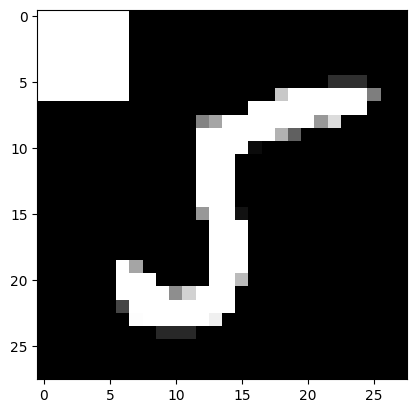

In [11]:
plt.imshow(clients[0].data[clients[0].poisoned_idx[0]], cmap="grey")

### Server Model Initialization and Metrics Definition

- **Random Key Splitting:**  
  `key, smodel_key = jrd.split(key, 2)` splits the random key so that one part is used for server model initialization.

- **Model Creation:**  
  `smodel = get_model(cfg.train.model, cfg.data.num_classes)` retrieves the model defined in the configuration for the specified number of classes.

- **Model Variables Initialization:**  
  `svars = smodel.init(smodel_key, jnp.ones((cfg.data.batch_size, *cfg.data.shape)), train=True)` initializes the model parameters using a dummy input tensor (a batch of ones).

- **Server Optimizer Setup:**  
  `stx = cfg.server.tx.fn(cfg.server.tx.lr)` creates the server's optimizer with the configured learning rate, and `state_stx = stx.init(svars)` initializes the optimizer's state using the model variables.

- **Client Optimizer Setup:**  
  `client_tx = cfg.worker.tx.fn(cfg.worker.tx.lr, cfg.worker.tx.moment)` sets up the optimizer for clients with a learning rate and momentum from the configuration.

- **Metrics Definition:**  
  The `Metrics` dataclass, built using Flax's `struct.dataclass` and `metrics.Collection`, defines two metrics:  
  - **loss:** Tracks the average loss.  
  - **accuracy:** Tracks the accuracy of predictions.

In [9]:
key, smodel_key = jrd.split(key, 2)
smodel = get_model(cfg.train.model, cfg.data.num_classes)

svars = smodel.init(smodel_key, jnp.ones((cfg.data.batch_size, *cfg.data.shape)), train=True)
stx = cfg.server.tx.fn(cfg.server.tx.lr)
state_stx = stx.init(svars)
client_tx = cfg.worker.tx.fn(cfg.worker.tx.lr, cfg.worker.tx.moment)

@struct.dataclass
class Metrics(metrics.Collection):
    loss: metrics.Average.from_output("loss")
    accuracy: metrics.Accuracy.from_output("accuracy")

In [10]:
wandb.login()
run = wandb.init(project=cfg.wandb.project, job_type=cfg.wandb.job_type,
                config=cfg.to_dict(), name=cfg.wandb.name)

tf.config.set_visible_devices([], 'GPU')

wandb: Currently logged in as: ata-shaker (cod-tum) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


### Server Training Loop and Logging

- **Initialization:**  
  - Create an empty DataFrame `log_df` to record training logs.
  - Iterate over server epochs with `for server_epoch in range(cfg.server.num_epochs)`.

- **Epoch Setup:**  
  - Record the start time of the epoch.
  - Initialize a `log_row` Series to store metrics and set a counter for active clients.
  - Initialize aggregate gradient trees (`agg_grads` and `agg_grads_signs`) with zeros matching the shape of the model variables.

- **Client Training:**  
  - For each client in the client list:
    - Check if the client is active during the current server epoch.
    - If active:
      - Split the random key to generate a client-specific key.
      - Increment the active client counter.
      - Initialize the client optimizer state.
      - Train the client using `train_client` to compute gradients.
      - Aggregate the client gradients into `agg_grads` and accumulate the sign of gradients into `agg_grads_signs`.

- **Server Update:**  
  - After processing all clients, compute the epoch duration.
  - If the number of active clients meets the threshold:
    - Compute a mask on the aggregated gradient signs based on a threshold (`cfg.rlr.thresh`).
    - Average the aggregated gradients by the number of active clients.
    - Apply the mask to obtain `agg_grads_rlr`.
    - Update the server model parameters using the server optimizer (`stx`), and apply the computed updates.

- **Evaluation and Logging:**  
  - Test the updated server model on both test and validation datasets using `test_client`.
  - Log the validation and test losses and accuracies.
  - Additionally, test on poisoned (attack) samples and log these metrics.
  - Record the epoch runtime in `log_row`.
  - Append `log_row` to `log_df`.

- **Finalization:**  
  - Update Weights & Biases (wandb) configuration with the current settings.
  - Finish the wandb run.

In [11]:
log_df = pd.DataFrame()
for server_epoch in range(cfg.server.num_epochs):
    epoch_start_time = datetime.now()
    print(f"Server Epoch {server_epoch + 1} Started...")
    log_row = pd.Series()
    num_active_clients = 0
    # agg_params = jax.tree.map(lambda x: jnp.zeros_like(x), svars)
    agg_grads = jtr.map(lambda x: jnp.zeros_like(x), svars)
    agg_grads_signs = jtr.map(lambda x: jnp.zeros_like(x), svars)

    for client in clients:
        if client.active[server_epoch]:
            print(f"Training on Client {client.client_id + 1}...")
            key, client_key = jrd.split(key)
            num_active_clients += 1
            state_client_tx = client_tx.init(svars)
            # client_params, log_row = train_client(client_key, client, smodel,
            #                             svars, client_tx,
            #                             state_client_tx, cfg.train.loss_fn, 
            #                             client.epochs[server_epoch],
            #                             cfg.data.batch_size, num_classes,
            #                                 cfg.train.batchwise_update, log_row)
            # agg_params = jax.tree.map(lambda x, y: x + y, agg_params, client_params)
            
            client_grad = train_client(client_key, client, smodel,
                            svars, client_tx,
                            state_client_tx, cfg.train.loss_fn,
                            client.epochs[server_epoch],
                            cfg.data.batch_size, num_classes,
                            cfg.train.batchwise_update,
                            log_row,
                            cfg.quantization)
            agg_grads = jax.tree.map(lambda x, y: x + y, agg_grads, client_grad)
            agg_grads_signs = jax.tree.map(lambda x, y: x + jnp.sign(y), agg_grads_signs, client_grad)
    
    epoch_end_time = datetime.now()

    if num_active_clients >= len(clients) * cfg.server.update_thresh:
        # agg_params = jax.tree.map(lambda x: x / num_active_clients, agg_params)
        # svars = agg_params
        # agg_grads = jax.tree.map(lambda x, y: x - y, svars, agg_params)
        # updates, state_server_tx = server_tx.update(agg_grads, state_server_tx, svars)
        # svars = optax.apply_updates(client_params, updates)
        
        agg_grads_signs_mask = jtr.map(lambda x: jnp.abs(x) >= cfg.rlr.thresh, agg_grads_signs)
        agg_grads = jax.tree.map(lambda x: x / num_active_clients, agg_grads)
        agg_grads_rlr = otu.tree_mul(agg_grads_signs_mask, agg_grads)
        updates, state_server_tx = stx.update(agg_grads_rlr, state_stx, svars)
        svars = optax.apply_updates(svars, updates)        

        # for label_clss in jnp.unique(Client.test_labels):
        #     tindices = jnp.where(Client.test_labels == label_clss)[0]
        #     vindices = jnp.where(Client.valid_labels == label_clss)[0]
        #     tdata = Client.test_data[tindices]
        #     tlabels = Client.test_data[tindices]
        #     vdata = Client.valid_data[vindices]
        #     vlabels = Client.valid_labels[vindices]
        #     test_loss, test_acc = test_client(smodel, svars, cfg.train.loss_fn, tdata, tlabels, num_classes)
        #     valid_loss, valid_acc = test_client(smodel, svars, cfg.train.loss_fn, vdata, vlabels, num_classes)
        #     log_row = log(log_row, server_epoch, 
        #                     {f"Server Validation Loss {label_clss}": valid_loss, 
        #                     f"Server Validation Accuracy {label_clss}": valid_acc,
        #                     f"Server Test Loss {label_clss}": test_loss, 
        #                     f"Server Test Accuracy {label_clss}": test_acc})

        test_loss, test_acc = test_client(smodel, svars, cfg.train.loss_fn, Client.test_data, Client.test_labels, num_classes)
        valid_loss, valid_acc = test_client(smodel, svars, cfg.train.loss_fn, Client.valid_data, Client.valid_labels, num_classes)
        log_row = log(log_row, server_epoch, 
                        {"Server Validation Loss": valid_loss, 
                        "Server Validation Accuracy": valid_acc,
                        "Server Test Loss": test_loss, 
                        "Server Test Accuracy": test_acc})

        attack_data = Client.test_data[Client.test_poisoned_idx]
        attack_labels = Client.test_labels[Client.test_poisoned_idx]
        attack_loss, attack_acc = test_client(smodel, svars, cfg.train.loss_fn, attack_data, attack_labels, num_classes)
        log_row = log(log_row, server_epoch, 
                        {"Server Attack Test Loss": attack_loss, 
                        "Server Attack Accuracy": attack_acc})
        
        # print(f"Server Validation Loss: {valid_loss}, Server Validation Accuracy: {valid_acc}")
        # print(f"Server Test Loss: {test_loss}, Server Test Accuracy: {test_acc}")
    else:
        print("Not enough active clients to update the server model")
        print(f"Server Epoch {server_epoch + 1} skipped...")
    
    print(f'Server Epoch {server_epoch + 1} is completed in {(epoch_end_time - epoch_start_time).total_seconds()} seconds.')
    log_row = log(log_row, server_epoch, {f'Server Run Time': (epoch_end_time - epoch_start_time).total_seconds()})
    if log_df.empty:
        log_df = log_row.to_frame().T
    else:
        log_df.loc[len(log_df)] = log_row

log_df['Run'] = cfg.wandb.name
wandb.config.update(cfg.to_dict(), allow_val_change=True)
run.finish()

Server Epoch 1 Started...
Training on Client 1...
Training on Client 2...
Training on Client 3...
Training on Client 4...
Training on Client 5...
Training on Client 6...
Training on Client 7...
Training on Client 8...
Training on Client 9...
Training on Client 10...
Server Epoch 1 is completed in 6.042219 seconds.
Server Epoch 2 Started...
Training on Client 1...
Training on Client 2...
Training on Client 3...
Training on Client 4...
Training on Client 5...
Training on Client 6...
Training on Client 7...
Training on Client 8...
Training on Client 9...
Training on Client 10...
Server Epoch 2 is completed in 4.605809 seconds.
Server Epoch 3 Started...
Training on Client 1...
Training on Client 2...
Training on Client 3...
Training on Client 4...
Training on Client 5...
Training on Client 6...
Training on Client 7...
Training on Client 8...
Training on Client 9...
Training on Client 10...
Server Epoch 3 is completed in 4.642686 seconds.
Server Epoch 4 Started...
Training on Client 1...
Tr

Server Attack Accuracy,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
Server Attack Test Loss,▅██▇▇▇▇▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Server Run Time,█▁▁▁▁▂▂▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▃▂▂▂▂▂▂▃
Server Test Accuracy,▁▆▆▆▇▇▇▇▇▇▇▇████████████████████████████
Server Test Loss,█▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Server Validation Accuracy,▁▆▇▇▇▇▇▇▇███████████████████████████████
Server Validation Loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Worker 1's Local Accuracy,▁▇▇▇▇█▇█▇███████████████████████████████
Worker 1's Local Loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Worker 1's Test Accuracy,▁▆▆▆▇▇▇▇▇█▇█████████████████████████████
Worker 1's Test Loss,█▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
